In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/ISIC_0024371.jpg
/kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/ISIC_0024358.jpg
/kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/ISIC_0024337.jpg
/kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/ISIC_0024382.jpg
/kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/ISIC_0024420.jpg
/kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/ISIC_0024409.jpg
/kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration

In [2]:
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, concatenate, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras.callbacks import EarlyStopping
from keras.layers.core import SpatialDropout2D
from keras import backend as K
from keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from warnings import filterwarnings

filterwarnings('ignore')
np.random.seed(101)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [6]:
train_path = '../input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
test_path = '../input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test'

In [18]:
import pathlib
data_dir = pathlib.Path(train_path)


In [19]:
image_count1 = len(list(data_dir.glob('*/*.jpg')))
print(image_count1)


2239


In [11]:
batch_size = 32
img_height = 180
img_width = 180

In [20]:


classes=['pigmented benign keratosis',
 'melanoma',
 'vascular lesion',
 'actinic keratosis',
 'squamous cell carcinoma',
 'basal cell carcinoma',
 'seborrheic keratosis',
 'dermatofibroma',
 'nevus']

In [21]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [22]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [23]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


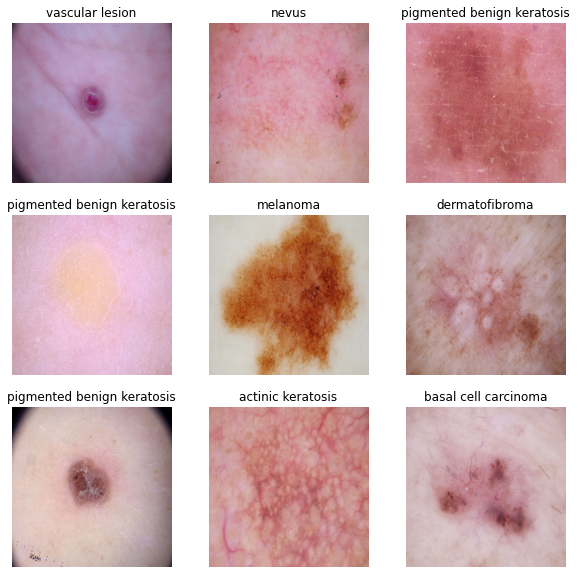

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [25]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [26]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [27]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [29]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.02401961 0.9385622


In [30]:
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [77]:
num_classes = 9

model1 = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='sigmoid'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='sigmoid'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='sigmoid'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='sigmoid'),
  layers.Dense(num_classes)
])

In [31]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [33]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
56/56 [==============================] - 40s 712ms/step - loss: 2.0411 - accuracy: 0.2034 - val_loss: 1.7706 - val_accuracy: 0.3960
Epoch 2/10
56/56 [==============================] - 32s 570ms/step - loss: 1.5642 - accuracy: 0.4450 - val_loss: 1.4504 - val_accuracy: 0.5302
Epoch 3/10
56/56 [==============================] - 32s 574ms/step - loss: 1.4263 - accuracy: 0.4913 - val_loss: 1.4101 - val_accuracy: 0.5369
Epoch 4/10
56/56 [==============================] - 32s 573ms/step - loss: 1.2520 - accuracy: 0.5492 - val_loss: 1.4178 - val_accuracy: 0.5257
Epoch 5/10
56/56 [==============================] - 32s 569ms/step - loss: 1.2458 - accuracy: 0.5551 - val_loss: 1.3588 - val_accuracy: 0.5570
Epoch 6/10
56/56 [==============================] - 32s 570ms/step - loss: 1.0868 - accuracy: 0.6284 - val_loss: 1.3505 - val_accuracy: 0.5257
Epoch 7/10
56/56 [==============================] - 32s 572ms/step - loss: 0.9290 - accuracy: 0.6643 - val_loss: 1.4076 - val_accuracy: 0.5503

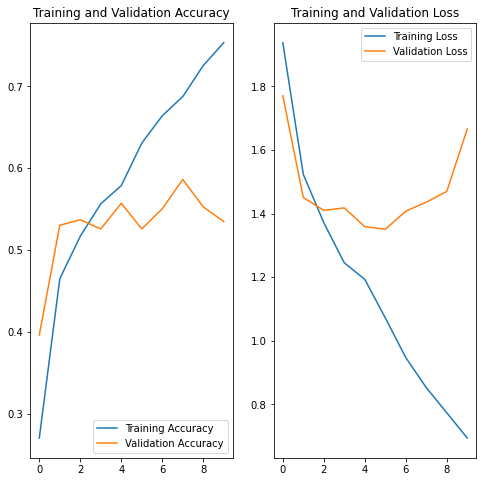

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As you can see, this has achieved only 68%

In [35]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

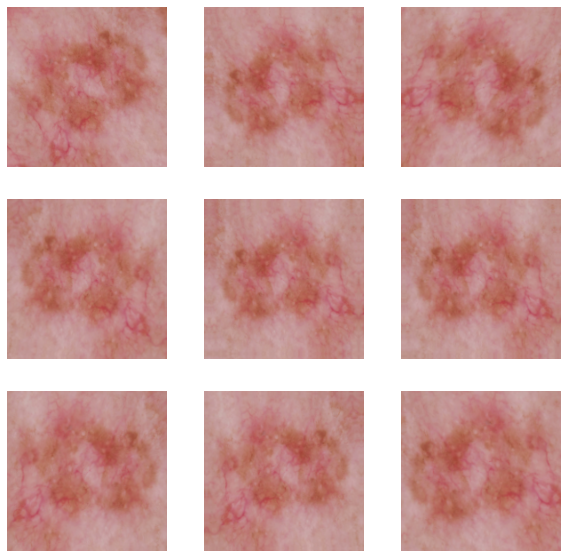

In [36]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [37]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [38]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [39]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [40]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
56/56 [==============================] - 38s 663ms/step - loss: 2.0321 - accuracy: 0.2516 - val_loss: 1.5538 - val_accuracy: 0.5011
Epoch 2/15
56/56 [==============================] - 37s 657ms/step - loss: 1.5836 - accuracy: 0.4442 - val_loss: 1.5346 - val_accuracy: 0.4743
Epoch 3/15
56/56 [==============================] - 37s 660ms/step - loss: 1.4308 - accuracy: 0.4898 - val_loss: 1.4551 - val_accuracy: 0.4899
Epoch 4/15
56/56 [==============================] - 37s 658ms/step - loss: 1.4877 - accuracy: 0.4920 - val_loss: 1.4440 - val_accuracy: 0.4832
Epoch 5/15
56/56 [==============================] - 37s 656ms/step - loss: 1.3813 - accuracy: 0.5013 - val_loss: 1.3495 - val_accuracy: 0.5503
Epoch 6/15
56/56 [==============================] - 37s 656ms/step - loss: 1.2735 - accuracy: 0.5523 - val_loss: 1.4292 - val_accuracy: 0.5078
Epoch 7/15
56/56 [==============================] - 37s 658ms/step - loss: 1.2990 - accuracy: 0.5378 - val_loss: 1.3308 - val_accuracy: 0.5347

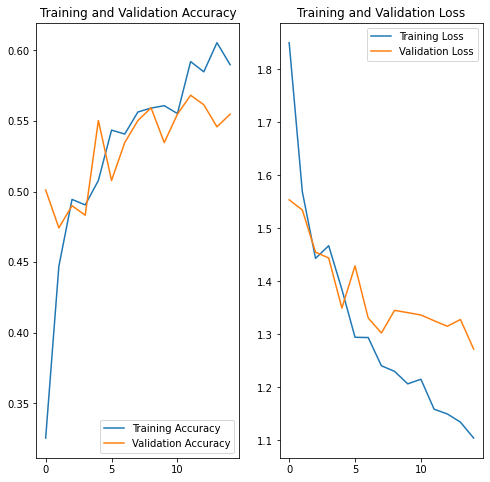

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

This model is still not good
It is high time we boost the model

In [42]:
pip install -q git+https://github.com/tensorflow/examples.git

  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.
Note: you may need to restart the kernel to use updated packages.


Image Segmentation

In [ ]:
from glob import glob

import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import datetime, os
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from IPython.display import clear_output
import tensorflow_addons as tfa

# For more information about autotune:
# https://www.tensorflow.org/guide/data_performance#prefetching
AUTOTUNE = tf.data.experimental.AUTOTUNE
print(f"Tensorflow ver. {tf.__version__}")

In [ ]:
SEED = 42
# you can change this path to reflect your own settings if necessary
dataset_path = "data/ADEChallengeData2016/images/"
training_data = "training/"
val_data = "validation/"

In [47]:

seed = 42
dataset_path = data_dir
training_data = train_ds
val_data = val_ds

In [56]:
def parse_image(img_path: str) -> dict:
    """Load an image and its annotation (mask) and returning
    a dictionary.

    Parameters
    ----------
    img_path : str
        Image (not the mask) location.

    Returns
    -------
    dict
        Dictionary mapping an image and its annotation.
    """
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)

    mask_path = tf.strings.regex_replace(img_path, "images", "annotations")
    mask_path = tf.strings.regex_replace(mask_path, "jpg")
    mask = tf.io.read_file(mask_path)
    # The masks contain a class index for each pixels
    mask = tf.image.decode_png(mask, channels=1)
    # In scene parsing, "not labeled" = 255
    # But it will mess up with our N_CLASS = 150
    # Since 255 means the 255th class
    # Which doesn't exist
    mask = tf.where(mask == 255, np.dtype('uint8').type(0), mask)
    # Note that we have to convert the new value (0)
    # With the same dtype than the tensor itself

    return {'image': image, 'segmentation_mask': mask}

In [57]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

In [58]:
# Image size that we are going to use
IMG_SIZE = 128
# Our images are RGB (3 channels)
N_CHANNELS = 3
# Isic images has 9 classes + `not labeled`
N_CLASSES = 9

In [59]:
def parse_image(img_path: str) -> dict:
    """Load an image and its annotation (mask) and returning
    a dictionary.

    Parameters
    ----------
    img_path : str
        Image (not the mask) location.

    Returns
    -------
    dict
        Dictionary mapping an image and its annotation.
    """
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)
    mask_path = tf.strings.regex_replace(img_path, "images", "annotations")
    mask_path = tf.strings.regex_replace(mask_path, "jpg")
    mask = tf.io.read_file(mask_path)
    # The masks contain a class index for each pixels
    mask = tf.image.decode_png(mask, channels=1)
    # In scene parsing, "not labeled" = 255
    # But it will mess up with our N_CLASS = 150
    # Since 255 means the 255th class
    # Which doesn't exist
    mask = tf.where(mask == 255, np.dtype('uint8').type(0), mask)
    # Note that we have to convert the new value (0)
    # With the same dtype than the tensor itself

    return {'image': image, 'segmentation_mask': mask}

In [60]:
@tf.function
def normalize(input_image: tf.Tensor, input_mask: tf.Tensor) -> tuple:
    """Rescale the pixel values of the images between 0.0 and 1.0
    compared to [0,255] originally.

    Parameters
    ----------
    input_image : tf.Tensor
        Tensorflow tensor containing an image of size [SIZE,SIZE,3].
    input_mask : tf.Tensor
        Tensorflow tensor containing an annotation of size [SIZE,SIZE,1].

    Returns
    -------
    tuple
        Normalized image and its annotation.
    """
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

@tf.function
def load_image_train(datapoint: dict) -> tuple:
    """Apply some transformations to an input dictionary
    containing a train image and its annotation.

    Notes
    -----
    An annotation is a regular  channel image.
    If a transformation such as rotation is applied to the image,
    the same transformation has to be applied on the annotation also.

    Parameters
    ----------
    datapoint : dict
        A dict containing an image and its annotation.

    Returns
    -------
    tuple
        A modified image and its annotation.
    """
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

@tf.function
def load_image_test(datapoint: dict) -> tuple:
    """Normalize and resize a test image and its annotation.

    Notes
    -----
    Since this is for the test set, we don't need to apply
    any data augmentation technique.

    Parameters
    ----------
    datapoint : dict
        A dict containing an image and its annotation.

    Returns
    -------
    tuple
        A modified image and its annotation.
    """
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask


UNET SEGMENTATION

In [64]:
from PIL import Image

im = Image.open('/kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test/melanoma/ISIC_0000046.jpg')


print(im.size)
print(type(im.size))


w, h = im.size
print('width: ', w)
print('height:', h)


(1504, 1129)
<class 'tuple'>
width:  1504
height: 1129


In [70]:
import os

input_dir = data_dir
target_dir = data_dir
img_size = (1504, 1129)
num_classes = 9
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".jpg") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 0


In [71]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

model = ResNet50(weights='imagenet')

102973440/102967424 [==============================] - 1s 0us/step


In [74]:
img_path = '/kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0000139.jpg'
img = image.load_img(img_path, target_size=(1504, 1129))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])

ValueError: in user code:

    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1478 predict_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1461 run_step  **
        outputs = model.predict_step(data)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1434 predict_step
        return self(x, training=False)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:274 assert_input_compatibility
        ', found shape=' + display_shape(x.shape))

    ValueError: Input 0 is incompatible with layer resnet50: expected shape=(None, 224, 224, 3), found shape=(None, 1504, 1129, 3)


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

In [ ]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)